In [ ]:

from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [1]:
# install requirements
!pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install torch torchvision opencv-python numpy

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-7hjn4ugp
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-7hjn4ugp
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36587 sha256=3ddb27b3cd28fd17ec723bfab81aa27eb7f4ab7312c675edf4f451eb2625f4e6
  Stored in directory: /tmp/pip-ephem-wheel-cache-l0wpwem3/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything


In [2]:
# create segment anything model predictor
import os

from segment_anything import SamPredictor, sam_model_registry


model_path = './sam_vit_b_01ec64.pth'
if not os.path.exists(model_path):
  !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

sam = sam_model_registry["vit_b"](checkpoint=model_path)
predictor = SamPredictor(sam)


--2024-02-23 22:10:01--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.173.166.31, 18.173.166.48, 18.173.166.51, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.173.166.31|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 375042383 (358M) [binary/octet-stream]
Saving to: ‘sam_vit_b_01ec64.pth’

sam_vit_b_01ec64.pt 100%[===================>] 357.67M   106MB/s    in 4.0s    

2024-02-23 22:10:05 (88.5 MB/s) - ‘sam_vit_b_01ec64.pth’ saved [375042383/375042383]



In [13]:
# # load image and select x, y coordinates to test
import cv2

x = 528
y = 606

image = cv2.imread('/content/Image.jpg')

In [14]:
# use sam predictor on (image, x, y) to get location of subject
import numpy as np


predictor.set_image(image)

masks, scores, logits = predictor.predict(
                                  point_coords=np.asarray([[x, y]]),
                                  point_labels=np.asarray([1]),
                                  multimask_output=True
                              )

C, H, W = masks.shape

result_mask = np.zeros((H, W), dtype=bool)

for j in range(C):
  result_mask |= masks[j, :, :]

result_mask = result_mask.astype(np.uint8)

In [15]:
# remove background
alpha_channel = np.ones(result_mask.shape, dtype=result_mask.dtype) * 255

alpha_channel[result_mask == 0] = 0

result_image = cv2.merge((image, alpha_channel))

In [7]:
# wrap it up as a function
import base64
import os

from segment_anything import SamPredictor, sam_model_registry
import cv2
import numpy as np


model_path = './sam_vit_b_01ec64.pth'
if not os.path.exists(model_path):
  !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

sam = sam_model_registry["vit_b"](checkpoint=model_path)
predictor = SamPredictor(sam)


def remove_background(image_base64_encoding, x, y):

  image_bytes = base64.b64decode(image_base64_encoding)

  image = cv2.imdecode(np.frombuffer(image_bytes, dtype=np.uint8), cv2.IMREAD_COLOR)

  predictor.set_image(image)

  masks, scores, logits = predictor.predict(
                                    point_coords=np.asarray([[x, y]]),
                                    point_labels=np.asarray([1]),
                                    multimask_output=True
                                )

  C, H, W = masks.shape

  result_mask = np.zeros((H, W), dtype=bool)

  for j in range(C):
    result_mask |= masks[j, :, :]

  result_mask = result_mask.astype(np.uint8)

  alpha_channel = np.ones(result_mask.shape, dtype=result_mask.dtype) * 255

  alpha_channel[result_mask == 0] = 0

  result_image = cv2.merge((image, alpha_channel))

  _, result_image_bytes = cv2.imencode('.png', result_image)

  result_image_bytes = result_image_bytes.tobytes()

  result_image_bytes_encoded_base64 = base64.b64encode(result_image_bytes).decode('utf-8')

  return result_image_bytes_encoded_base64

In [9]:
import matplotlib.pyplot as plt


x = 528
y = 606
image = cv2.imread('/content/Image.jpg')

_, image_bytes = cv2.imencode('.png', image)

image_bytes = image_bytes.tobytes()

image_bytes_encoded_base64 = base64.b64encode(image_bytes).decode('utf-8')

result_image = remove_background(image_bytes_encoded_base64, x, y)

result_image_bytes = base64.b64decode(result_image)

result_image = cv2.imdecode(np.frombuffer(result_image_bytes, dtype=np.uint8), cv2.IMREAD_UNCHANGED)

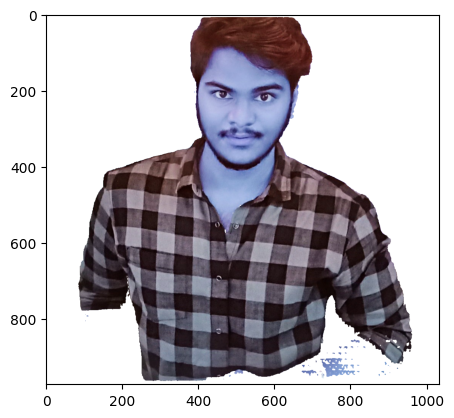

In [10]:
plt.imshow(result_image)
plt.show()

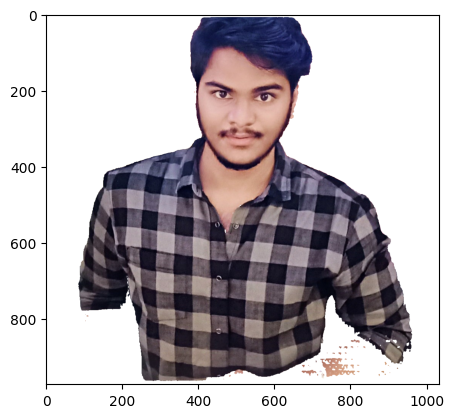

In [11]:
plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGRA2RGBA))
plt.show()

## Model Deployment Using Modelbit

In [25]:
!pip install modelbit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 50.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 13.1 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of types-requests to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of types-requests to determine which version is compatible with other requirements. This could take a while.
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.0.7
    Uninstalling urllib3-2.0.7:
      Successfully 

In [1]:
import modelbit

mb = modelbit.login()

In [8]:
mb.deploy(remove_background)

Uploading 'predictor': 100%|██████████| 348M/348M [00:04<00:00, 79.8MB/s]


## Testing The API Endpoint

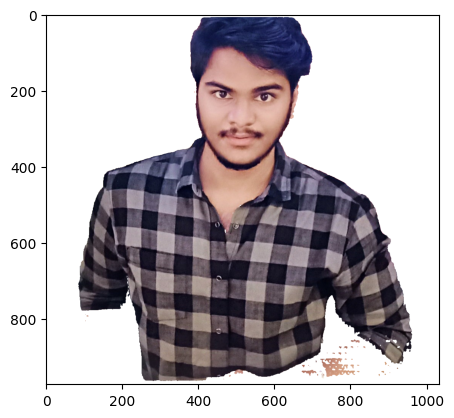

In [15]:
import cv2
import matplotlib.pyplot as plt
import requests


api_endpoint = 'https://tvrraviteja.app.modelbit.com/v1/remove_background/latest' #your api endpoint


image_path = '/content/Image.jpg'

x = 528
y = 606

image = cv2.imread(image_path)

_, image_bytes = cv2.imencode('.png', image)

image_bytes = image_bytes.tobytes()

image_bytes_encoded_base64 = base64.b64encode(image_bytes).decode('utf-8')

api_data = {"data": [image_bytes_encoded_base64, x, y]}
response = requests.post(api_endpoint, json=api_data)

result_image = response.json()['data']

result_image_bytes = base64.b64decode(result_image)

result_image = cv2.imdecode(np.frombuffer(result_image_bytes, dtype=np.uint8), cv2.IMREAD_UNCHANGED)

plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGRA2RGBA))
plt.show()

API Response: {'data': 'iVBORw0KGgoAAAANSUhEUgAABAoAAAPMCAYAAADLslsLAAAgAElEQVR4AaTB+46lZ34e1vX83l3VzSFn5NHIgc6yEfgCcw/5M9eTIFcSQEEMGYoNxTrOieyqvb/3Cb+9XexukjN2nLXy9Mzt5jutuyxagm5ccHhYONxd9jNqGZ2btg5bSyw1imXUFge2GY6yfWstaXVvylpxOo46zYzd0DKLlsas0WPjanwUD0WMMWpU1WHirt22WGvZe9xl7L3VJqXFFg9jRDC2rQ6GxF08xMNxsFbsLqckjuPAttaTuLgd293TsDdzyITcuJYwZR/uEmqpoUhIcGMXG+M0eXKqcaqDlsHCcZVhGm3NXupQkUsdB1lk6MaBspyWY6JK464hIcWWtfT2ymDCMbS4kIMcTom7JpLQ0ZZsdtlkCPZGSZiyJqi9CRJ3LTO0tO4a32lZi71p3cVDPMSoqioaEhp6sLCQuDvqM/UQD+MhHg5RoyqiDt+3JtrY3cZF1aGW4LBERNX3VUWcqk4REVWjTjWqtjfjVIc3EaPebKdlq9MYO6Otqoiq03iIOgXF5OLWLSriTcRp2yKaaGurN5PR3gwiIqqq3kRURUQEVVVEUker4vsiTlWM02ScdreH7feZjFNbVYOIiIexbacxti0iYtsi3lTFOEWcaos4VbF9qipiGw/xMOKwjNgOh4h6qMOnIj4VYzucumhpyFxU2JuUXUkFLa2PwuxgsFWdIt407tp6GEm0cYqLJE5tsZ1G3KVObX1uqzpFnJJoD1W/y+Ti1EbV2CI+2qoikjhan6q6C8lIx67vrFlObe1uRMT3Vb2JiKiqOkWcIqp+TG0Xg62qinGqOFV9Lh7ioU4R31f1JuL7It5UfV9E1akq4hRRdYqoot4kcWrrVPWpiDdFVXw0Gae2iO+riqBMtYc2HsZDRCRxaquKukslkR0/puo0GW39LlURSZzaqjpFvEni1FbV

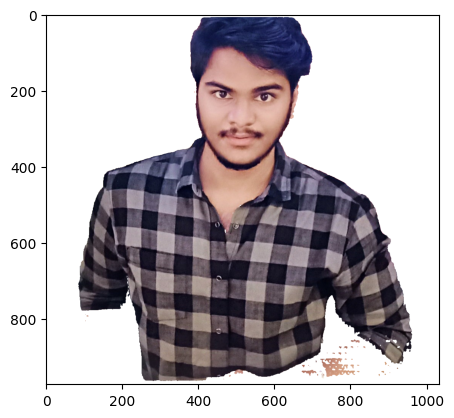

In [14]:
import cv2
import matplotlib.pyplot as plt
import requests
import base64
import numpy as np

api_endpoint = 'https://tvrraviteja.app.modelbit.com/v1/remove_background/latest'  # your api endpoint

image_path = '/content/Image.jpg'

x = 528
y = 606

image = cv2.imread(image_path)

_, image_bytes = cv2.imencode('.png', image)

image_bytes = image_bytes.tobytes()

image_bytes_encoded_base64 = base64.b64encode(image_bytes).decode('utf-8')

api_data = {"data": [image_bytes_encoded_base64, x, y]}
response = requests.post(api_endpoint, json=api_data)

# Print the full response to understand its structure
print("API Response:", response.json())

# Check if 'data' key exists in the response
if 'data' in response.json():
    result_image = response.json()['data']

    result_image_bytes = base64.b64decode(result_image)

    result_image = cv2.imdecode(np.frombuffer(result_image_bytes, dtype=np.uint8), cv2.IMREAD_UNCHANGED)

    plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGRA2RGBA))
    plt.show()
else:
    print("Key 'data' not found in the response. Please check the API response structure or contact the API provider for more details.")
